# Occupazione della stanza

Iniziamo a stimare gli iperparametri della Random Forest

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

SRC_DATASET = "./data/datatraining.txt"
SRC_DATASET_2 = "./data/datatest.txt"
FINAL_DATASET = "./data/datatest2.txt"

dataset = pd.read_csv(SRC_DATASET)
dataset2 = pd.read_csv(SRC_DATASET_2)
dataset = pd.concat([dataset, dataset2], ignore_index=True)

final_dataset = pd.read_csv(FINAL_DATASET)

def prepare_dataset(dataset_to_prepare):
    dataset_to_prepare["date"] = pd.to_datetime(dataset_to_prepare["date"], errors='coerce')
    dataset_to_prepare["weekday"] = dataset_to_prepare["date"].dt.weekday
    dataset_to_prepare["hour"] = dataset_to_prepare["date"].dt.round('h').dt.hour
    dataset_to_prepare = dataset_to_prepare.drop("date", axis=1)
    return dataset_to_prepare


dataset = prepare_dataset(dataset)
final_dataset = prepare_dataset(final_dataset)

# Funzione che divide il dataset in un dataset di training e uno di testing,
# dividendo in due dataset, secondo il parametro training_ratio (compreso fra 0 e 1),
# mantenendo le proporzioni del dataset iniziale (andando a campionare una frazione
# fissa di ogni gruppo dell'etichetta di classificazione)
def subsample_dataset(input_dataset, training_ratio, classification_label):
    training_dataset = (input_dataset.groupby(classification_label, group_keys=False)
                        .sample(frac=training_ratio))
    testing_dataset = input_dataset[~input_dataset.index.isin(training_dataset.index)]
    return training_dataset, testing_dataset

# Funzione che divide le features dalla verità dei fatti
def get_x_y(dataset, label):
    y = dataset[label]
    x = dataset.drop(label, axis="columns")
    return x, y


training, testing = subsample_dataset(dataset, training_ratio=0.75, classification_label="Occupancy")

X_train, y_train = get_x_y(training, "Occupancy")
X_test, y_test = get_x_y(testing, "Occupancy")


###
NUM_TRIALS = 50

param_grid = {
        'n_estimators': [100, 200, 500],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'max_samples': [0.5, 0.8, 1.0],
        'max_depth': [None, 10, 30]
    }

best_estimators_parameters = {
    'n_estimators': [],
    'min_samples_split': [],
    'min_samples_leaf': [],
    'max_samples': [],
    'max_depth': []
}

for i in range(NUM_TRIALS):
    rf = RandomForestClassifier(n_jobs=-1, random_state=i)

    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1) #usiamo 5-fold cross validation
    grid_search.fit(X_train, y_train)

    for param in grid_search.best_params_.keys():
        if param == 'max_depth' and grid_search.best_params_[param] is None:
            best_estimators_parameters[param].append(-1)
        else:
            best_estimators_parameters[param].append(grid_search.best_params_[param])

best_estimators_parameters = pd.DataFrame.from_dict(best_estimators_parameters)
best_estimators_parameters.to_csv("estimators_parameters.csv")
print(best_estimators_parameters)
print(best_estimators_parameters.mode())  #parametro 0 (default) si ottiene la moda per colonna


    n_estimators  min_samples_split  min_samples_leaf  max_samples  max_depth
0            500                  2                 1          0.5         -1
1            500                  2                 1          0.5         -1
2            200                  2                 1          0.5         -1
3            500                  2                 1          0.5         -1
4            500                  5                 1          1.0         -1
5            100                  2                 2          0.8         -1
6            500                  2                 1          0.5         -1
7            100                  5                 2          1.0         -1
8            500                  2                 1          0.5         -1
9            200                  2                 1          0.5         -1
10           200                  2                 1          0.5         -1
11           500                  5                 1          0

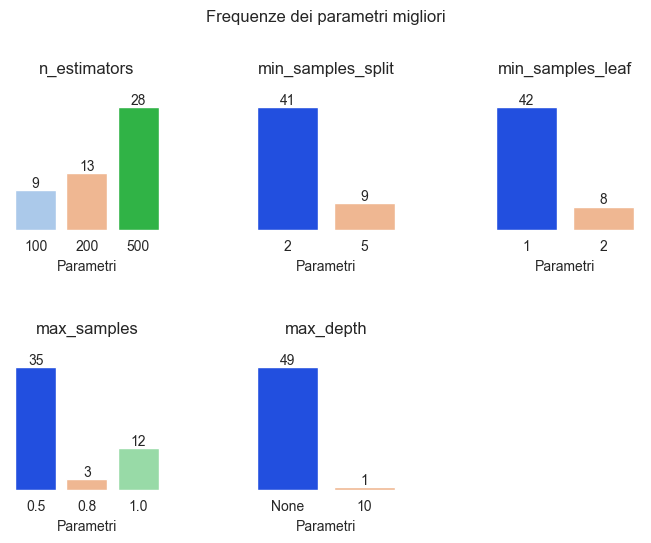

In [70]:
%store -r best_estimators_parameters

import seaborn as sns

params = best_estimators_parameters.columns.tolist()
n = len(params)
cols = 3
rows = 2
fig, axes = plt.subplots(rows, cols, constrained_layout=True)
fig.set_constrained_layout_pads(hspace=0.2, wspace=0.4)
axes = axes.flatten()

for i, param in enumerate(params):
    ax = axes[i]
    counts = best_estimators_parameters[param].astype(str).value_counts().sort_index()
    counts.index = counts.index.to_series().replace("-1", "None")
    palette = sns.color_palette("pastel", n_colors=len(counts))
    palette[counts.values.argmax()] = sns.color_palette("bright")[counts.values.argmax()]
    sns.barplot(x=counts.index, y=counts.values, ax=ax, palette=palette, hue=counts.index)
    ax.set_title(param)
    ax.set_xlabel('Parametri')
    ax.set(yticklabels=[])
    ax.set_title(param, pad=20)

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge')

    for spine in ax.spines.values():
        spine.set_visible(False)


for i in range(len(params), len(axes)):
    fig.delaxes(axes[i])


plt.suptitle('Frequenze dei parametri migliori', y=1.1)
plt.savefig("./plots/frequenze_parametri_migliori_50_grid_search.png", transparent=True)
plt.show()



-1
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2027
           1       0.98      0.99      0.98       675

    accuracy                           0.99      2702
   macro avg       0.99      0.99      0.99      2702
weighted avg       0.99      0.99      0.99      2702



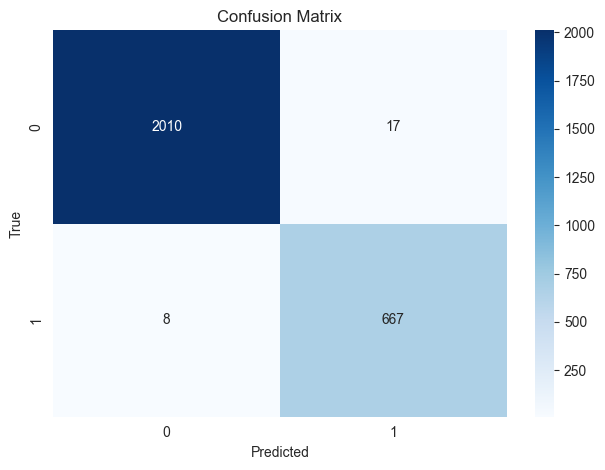

In [41]:
import sklearn.metrics._classification as sklearn_metrics

hyperparameters = best_estimators_parameters.mode()
max_depth = hyperparameters['max_depth'][0]

classifier_with_tuned_paramaters = RandomForestClassifier(
    n_jobs=-1, n_estimators=hyperparameters['n_estimators'][0],
    min_samples_split=hyperparameters['min_samples_split'][0],
    min_samples_leaf=hyperparameters['min_samples_leaf'][0],
    max_samples=hyperparameters['max_samples'][0],
    max_depth= None if max_depth == -1 else max_depth,
)

classifier_with_tuned_paramaters.fit(X_train, y_train)

y_pred = classifier_with_tuned_paramaters.predict(X_test)

labels = classifier_with_tuned_paramaters.classes_

print(sklearn_metrics.classification_report(y_test, y_pred))
confusion_matrix = sklearn_metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7703
           1       0.97      1.00      0.98      2049

    accuracy                           0.99      9752
   macro avg       0.99      0.99      0.99      9752
weighted avg       0.99      0.99      0.99      9752



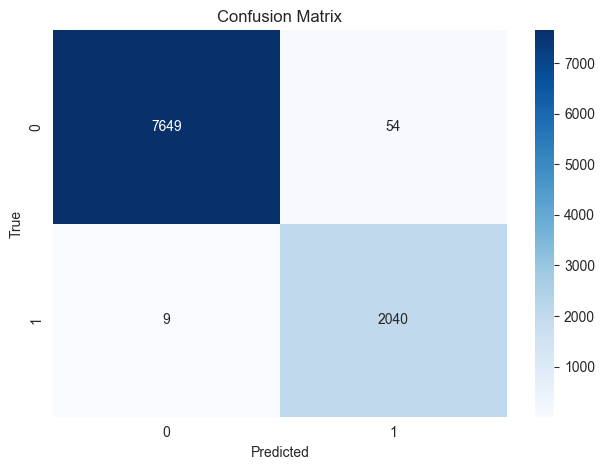

In [42]:
X_final_testing, y_final_testing = get_x_y(final_dataset, "Occupancy")

y_pred = classifier_with_tuned_paramaters.predict(X_final_testing)

confusion_matrix = sklearn_metrics.confusion_matrix(y_final_testing, y_pred)

print(sklearn_metrics.classification_report(y_final_testing, y_pred))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

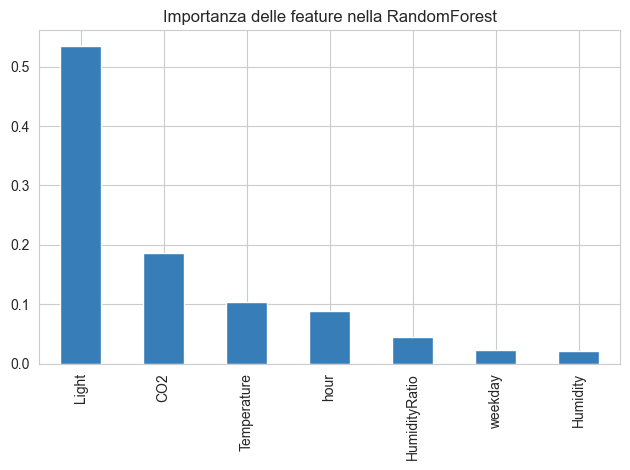

In [5]:
importances = pd.Series(classifier_with_tuned_paramaters.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure()
importances.plot.bar(color='#377eb8')
plt.title('Importanza delle feature nella RandomForest')
plt.tight_layout()
plt.show()

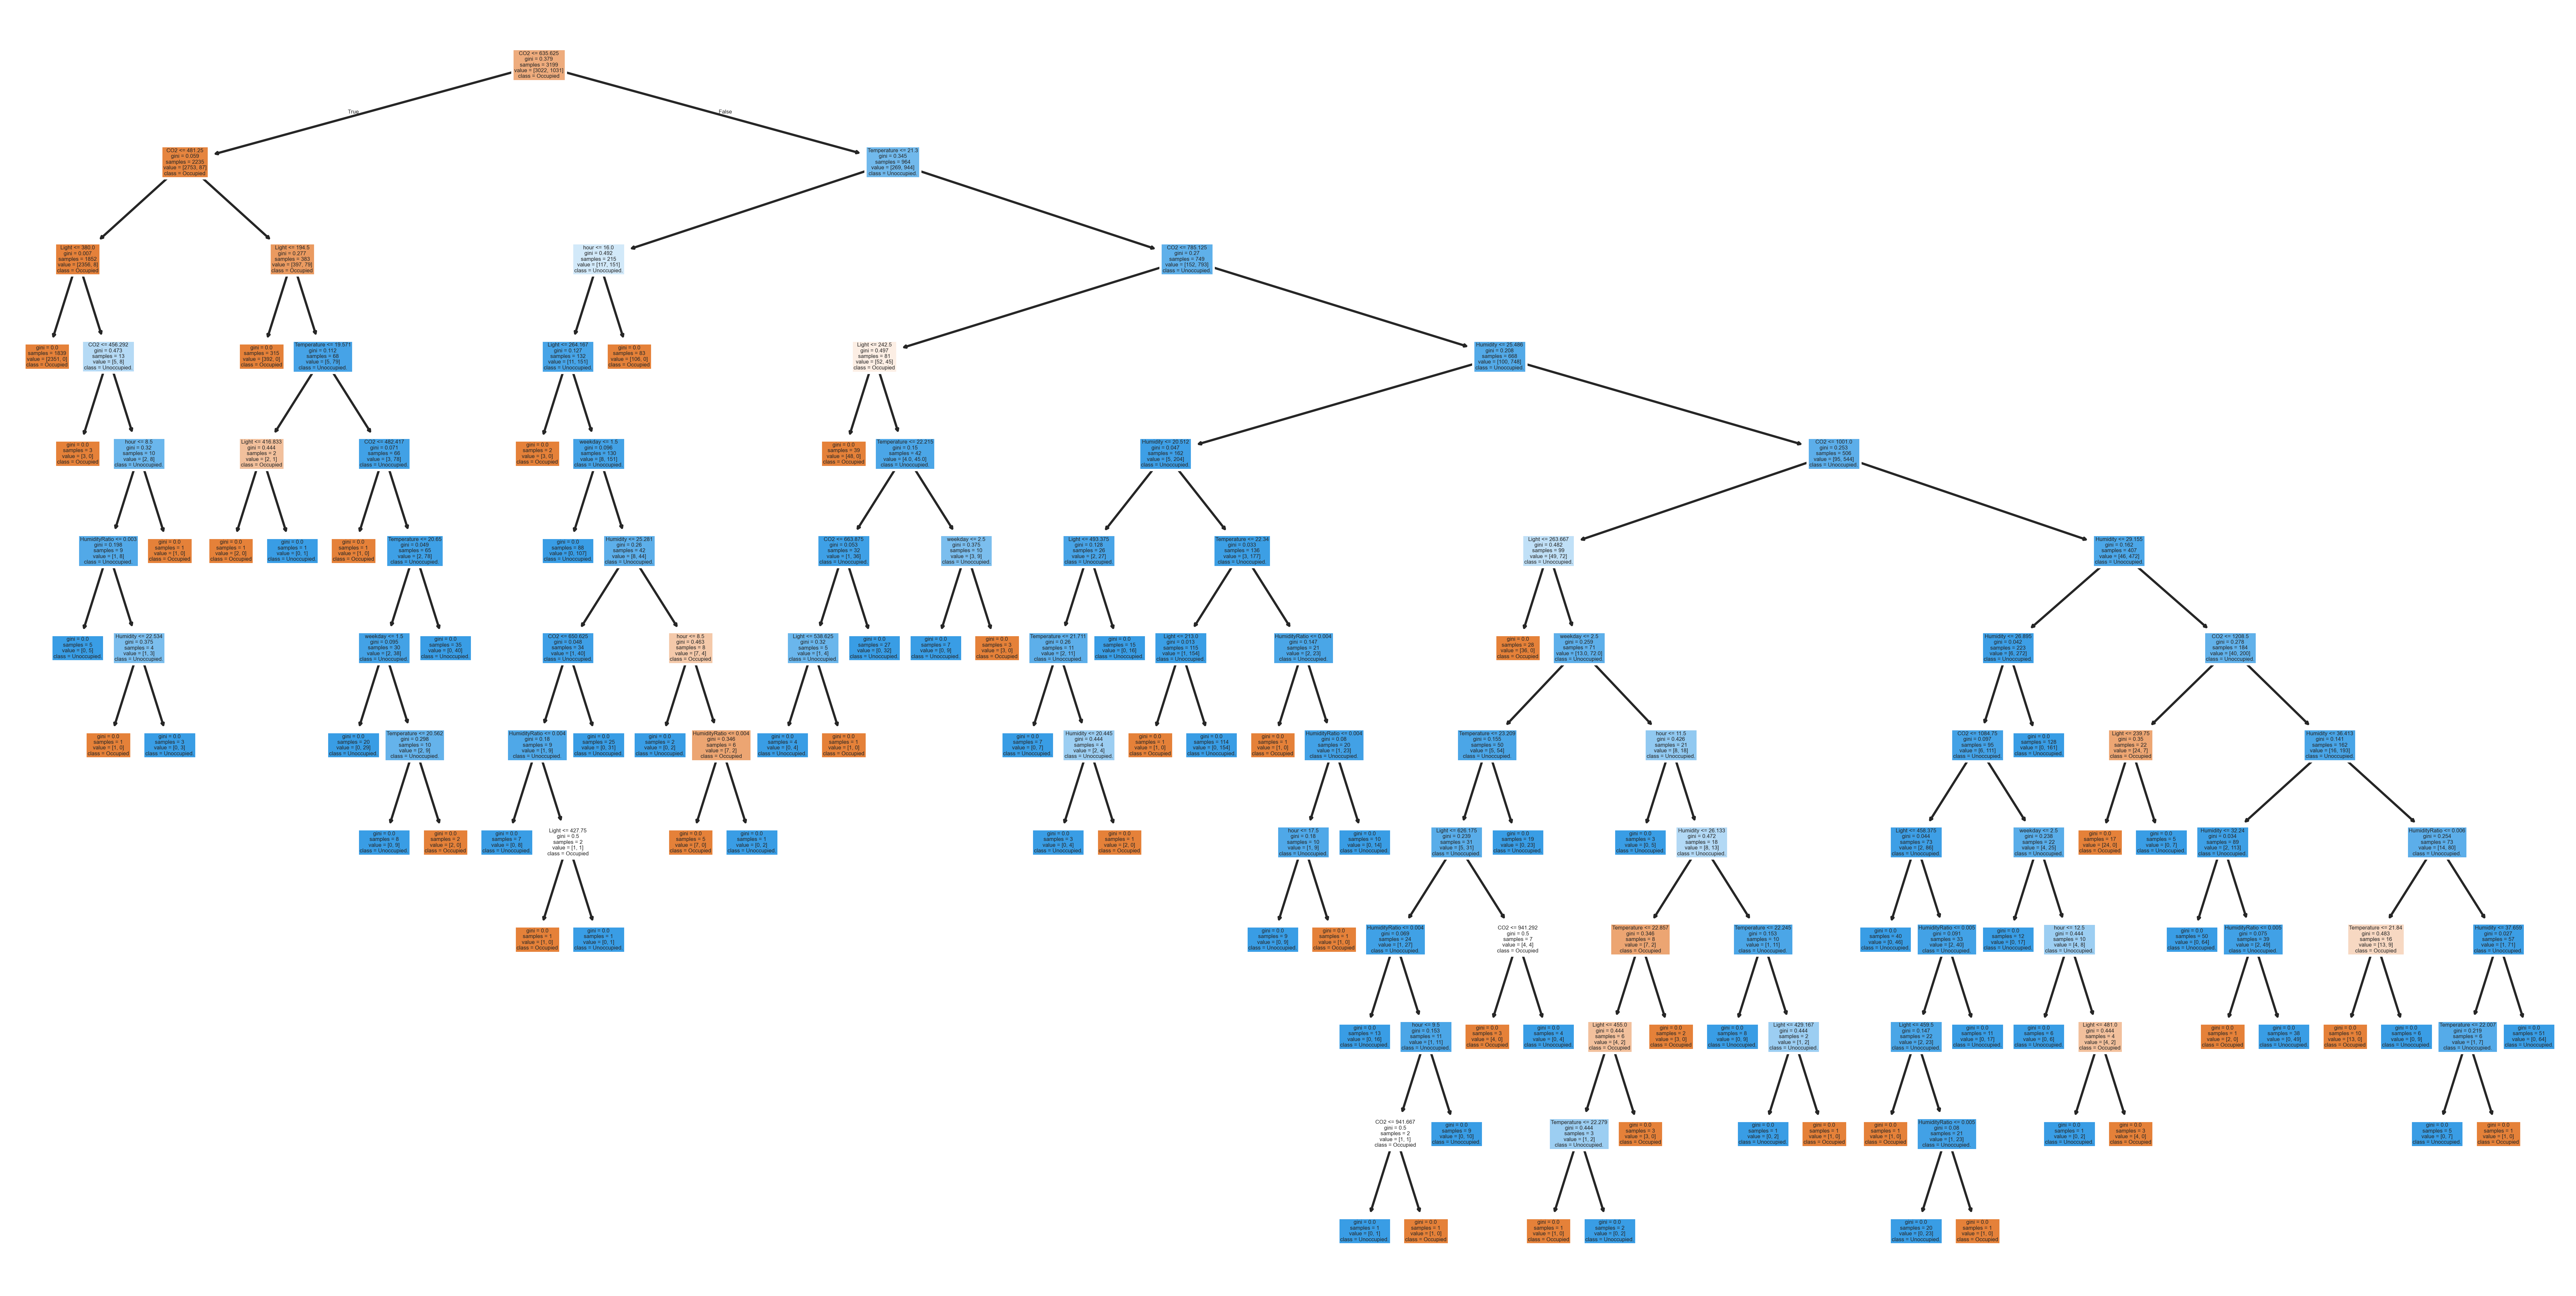

In [67]:
from sklearn.tree import plot_tree

# Visualizzare l'albero numero 425
plt.figure(figsize=(20, 10), dpi=500)
plot_tree(classifier_with_tuned_paramaters.estimators_[425],
          feature_names=X_train.columns,
          class_names=["Occupied", "Unoccupied."],
          filled=True)
plt.show()

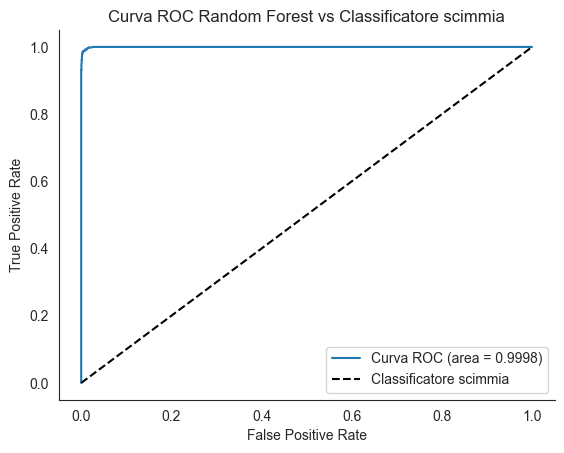

In [19]:
%store -r best_estimators_parameters
%store -r X_train
%store -r y_train
%store -r X_test
%store -r y_test

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

hyperparameters = best_estimators_parameters.mode()
max_depth = hyperparameters['max_depth'][0]

classifier_with_tuned_paramaters = RandomForestClassifier(
    n_jobs=-1, n_estimators=hyperparameters['n_estimators'][0],
    min_samples_split=hyperparameters['min_samples_split'][0],
    min_samples_leaf=hyperparameters['min_samples_leaf'][0],
    max_samples=hyperparameters['max_samples'][0],
    max_depth= None if max_depth == -1 else max_depth,
)

classifier_with_tuned_paramaters.fit(X_train, y_train)

y_pred_proba = classifier_with_tuned_paramaters.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

sns.set_style({'axes.grid' : False})

plt.plot(fpr, tpr, label="Curva ROC (area = %0.4f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--", label="Classificatore scimmia")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Random Forest vs Classificatore scimmia')
plt.legend(loc="lower right")
sns.despine()
plt.show()

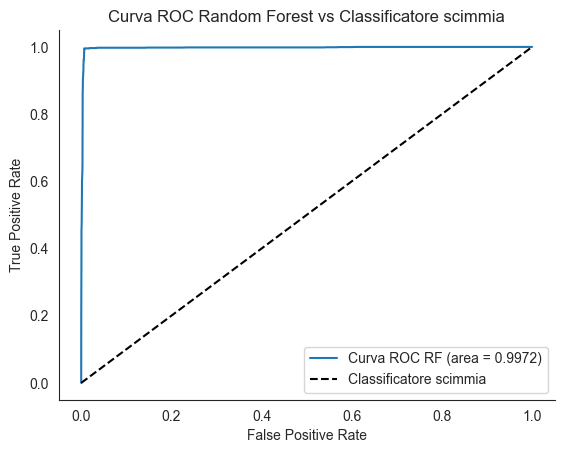

In [20]:
import pandas as pd

def prepare_dataset(dataset_to_prepare):
    dataset_to_prepare["date"] = pd.to_datetime(dataset_to_prepare["date"], errors='coerce')
    dataset_to_prepare["weekday"] = dataset_to_prepare["date"].dt.weekday
    dataset_to_prepare["hour"] = dataset_to_prepare["date"].dt.round('h').dt.hour
    dataset_to_prepare = dataset_to_prepare.drop("date", axis=1)
    return dataset_to_prepare

# Funzione che divide le features dalla verità dei fatti
def get_x_y(dataset, label):
    y = dataset[label]
    x = dataset.drop(label, axis="columns")
    return x, y

FINAL_DATASET = "./data/datatest2.txt"

final_dataset = pd.read_csv(FINAL_DATASET)

final_dataset = prepare_dataset(final_dataset)

X_final_testing, y_final_testing = get_x_y(final_dataset, "Occupancy")

y_pred_proba = classifier_with_tuned_paramaters.predict_proba(X_final_testing)[:, 1]

fpr, tpr, thresholds = roc_curve(y_final_testing, y_pred_proba)

roc_auc = roc_auc_score(y_final_testing, y_pred_proba)

sns.set_style({'axes.grid' : False})

plt.plot(fpr, tpr, label="Curva ROC RF (area = %0.4f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--", label="Classificatore scimmia")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Random Forest vs Classificatore scimmia')
plt.legend(loc="lower right")
sns.despine()
plt.show()